In [1]:
from binance_api import BinanceAPI

In [2]:
api = BinanceAPI(
    verbose=True,
    pair="BTCUSDT",
    difficulty="HIGH",
    use_fee=True,
    fee_maker=0.0002,
    fee_taker=0.0004,
    system="NETTING"
)

In [7]:
start = ["2023-10-01", "2023-08-01", "2023-12-10", "2023-11-01", "2024-02-03 23:47:00", "2023-01-01", "2022-01-01"]
end = ["2023-11-19", "2023-09-01", "2024-01-10", "2024-01-30", "2024-02-04 05:01:00", "2024-05-15", "2023-01-01"]
num = 5
data = api.load_data(
    interval_of_candles="1h",
    start_date_utc=start[num],
    end_date_utc=end[num],
)

Trying to load info from directory...
Data loaded.


In [8]:
import pandas as pd

chg24hs = []
for date, bar in data.iterrows():
    date_prev_24h = date - pd.Timedelta(hours=24)
    try:
        prev24h_bar = data.loc[date_prev_24h]
    except:
        continue
    chg24h = (bar["Close"] - prev24h_bar["Close"])/prev24h_bar["Close"] * 100
    chg24hs.append(chg24h)
# chg24hs

Text(0, 0.5, 'Frecuencia')

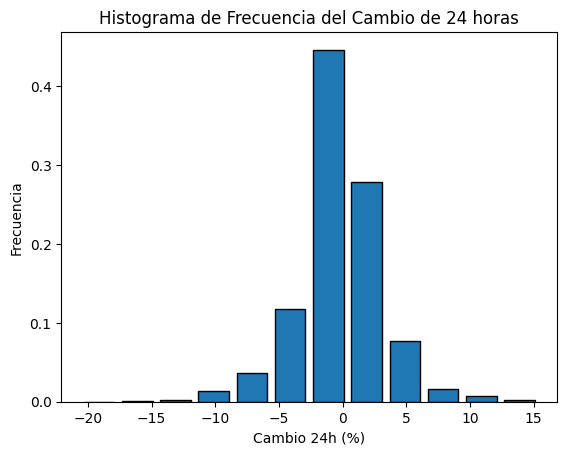

In [6]:
import matplotlib.pyplot as plt
import numpy as np
bins=np.arange(min(chg24hs), max(chg24hs), 3) - 1.5
plt.hist(chg24hs, bins=bins, edgecolor='black', rwidth=0.8, weights=np.zeros_like(chg24hs) + 1. / len(chg24hs))
plt.title('Histograma de Frecuencia del Cambio de 24 horas')
plt.xlabel('Cambio 24h (%)')
plt.ylabel('Frecuencia')


Text(0, 0.5, 'Frecuencia')

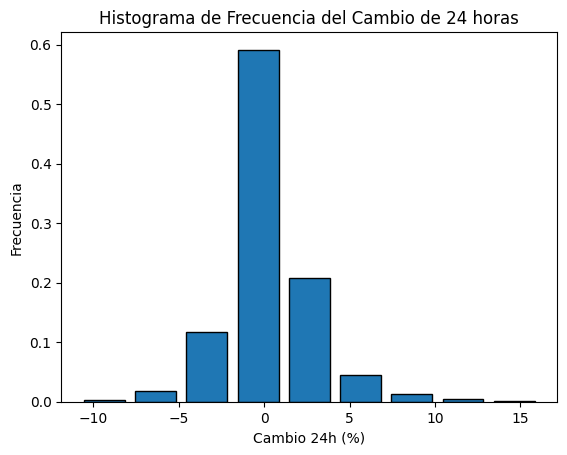

In [9]:
import matplotlib.pyplot as plt
import numpy as np
bins=np.arange(min(chg24hs), max(chg24hs), 3) - 1.5
plt.hist(chg24hs, bins=bins, edgecolor='black', rwidth=0.8, weights=np.zeros_like(chg24hs) + 1. / len(chg24hs))
plt.title('Histograma de Frecuencia del Cambio de 24 horas')
plt.xlabel('Cambio 24h (%)')
plt.ylabel('Frecuencia')

In [102]:
counts, bin_edges = np.histogram(chg24hs, bins=bins)
total_counts = sum(counts)
relative_frequencies = counts / total_counts * 100
relative_frequencies

for freq, izq, der in zip(relative_frequencies, bin_edges, bin_edges[1:]):
    print("En ", str(izq), "...", str(der), ": ", str(round(freq, 2)))

En  -13.5 ... -10.5 :  0.0
En  -10.5 ... -7.5 :  0.35
En  -7.5 ... -4.5 :  2.21
En  -4.5 ... -1.5 :  14.52
En  -1.5 ... 1.5 :  60.95
En  1.5 ... 4.5 :  16.66
En  4.5 ... 7.5 :  3.67
En  7.5 ... 10.5 :  1.25
En  10.5 ... 13.5 :  0.38


## METATRADER 5

//+------------------------------------------------------------------+
//| Script program start function                                    |
//+------------------------------------------------------------------+
#include <Trade\Trade.mqh>

//+------------------------------------------------------------------+
//| Script program start function                                    |
//+------------------------------------------------------------------+
void OnStart()
  {
   // Define the symbol
   string symbol = Symbol();
   
   // Create the file name with the symbol included
   string file_name = symbol + "_24h_changes.csv";

   // Get the current time and the time 365 days ago
   datetime now = TimeCurrent();
   datetime start_time = now - 365 * 24 * 60 * 60;  // 365 days ago

   // Create a file to save the data
   int file_handle = FileOpen(file_name, FILE_WRITE | FILE_CSV | FILE_SHARE_WRITE);
   if(file_handle != INVALID_HANDLE)
     {
      // Write the header
      FileWrite(file_handle, symbol);
      // Get the data for the last 365 days
      int bars = iBars(symbol, PERIOD_H1);
      for(int i = 24; i < bars; i++)
        {
         datetime time = iTime(symbol, PERIOD_H1, i);
         // if(time < start_time) break;

         double open = iClose(symbol, PERIOD_H1, i-24);
         double close = iClose(symbol, PERIOD_H1, i);
         double change = (close - open) / open * 100;

         // Write the data to the file
         FileWrite(file_handle, change);
        }

      // Close the file
      FileClose(file_handle);
      Print("Data successfully exported to ", file_name);
     }
   else
     {
      Print("Failed to open file!");
     }
  }
//+------------------------------------------------------------------+


In [4]:
import yfinance as yf
from datetime import datetime, timedelta
from collections import defaultdict
import pandas as pd

def get_currency_changes(tickers):
    changes = defaultdict(list)
    end_date = datetime(2024, 6, 1)#datetime.now()
    start_date = datetime(2024, 1, 1)# end_date - timedelta(days=365)
    #data = yf.download(tickers, start=start_date, end=end_date, interval='1h')
    for ticker in tickers:
        data = yf.download(ticker, start=start_date, end=end_date, interval='1h')
        close_prices = data["Close"]
        for curr_timestamp in close_prices.index:
            curr_val = close_prices.loc[curr_timestamp]
            try:
                prev_val = close_prices.loc[curr_timestamp - timedelta(days=1)]
            except KeyError:
                continue
            if pd.isnull(curr_val) or pd.isnull(prev_val):
                continue
            chg24h = (curr_val - prev_val)/ prev_val * 100
            changes[ticker].append(chg24h)

    return changes

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def make_histogram(name: str, changes: defaultdict):
    values = changes[name]

    # Calcular los percentiles deseados
    percentiles = [1, 4, 10, 90, 96, 99]
    percentile_values = np.percentile(values, percentiles)

    # Generar el histograma
    plt.hist(values, bins=10, edgecolor='black', weights=np.zeros_like(values) + 1. / len(values))
    plt.title('Histograma de los Cambios de 24 Horas de ' + name)
    plt.xlabel('Cambio (%)')
    plt.ylabel('Frecuencia')
    plt.grid(True)

    # Añadir líneas verticales para los percentiles
    for percentile_value in percentile_values:
        plt.axvline(percentile_value, color='r', linestyle='--')

    # Mostrar el histograma
    plt.show()

    # Imprimir los percentiles y sus valores correspondientes
    for i, percentile in enumerate(percentiles):
        print(f'Percentil {percentile}%: {percentile_values[i]}')


[*********************100%%**********************]  1 of 1 completed


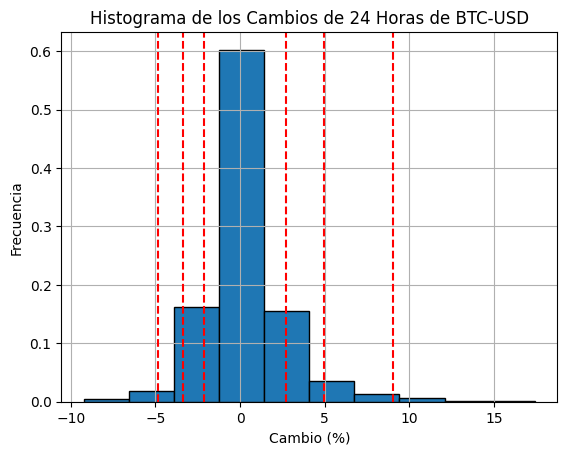

Percentil 1%: -4.871365100980953
Percentil 4%: -3.3447009613183165
Percentil 10%: -2.11673064639498
Percentil 90%: 2.7030530454460635
Percentil 96%: 4.942039060352356
Percentil 99%: 9.001733713905844


In [6]:
# Lista de pares de divisas
tickers_crypto = [
    "BTC-USD"
]

tickers_forex = [
    "EURUSD=X", "GBPUSD=X", "USDCHF=X", "USDJPY=X", "USDCAD=X",
    "AUDUSD=X","AUDNZD=X", "AUDCAD=X", "AUDCHF=X", "AUDJPY=X", 
    "AUDCHF=X", "AUDCHF=X", "AUDCHF=X", "AUDCHF=X"
]

tickers_indices = [
    "^GSPC",  # SP500
    "^FTSE",  # UK 100 (FTSE 100)
    "^NDX",   # Nasdaq 100
    "^N225",  # Japan 225 (Nikkei 225)
    "^GDAXI", # DAX 40
    "^DJI"    # Dow Jones Industrial Average (US 30)
]

tickers_metals =  [
    "XAGUSD=X"
    "XAUUSD=X"
]

tickers_energy = [

]

changes = get_currency_changes(tickers_crypto)

for ticker in changes.keys():
    make_histogram(ticker, changes)

### Criptomonedas

| Asset    | Percentil 90 | Percentil 96 | Percentil 99 |
|----------|---------------|---------------|---------------|
| BTC-USD  |       2.5     |      5        |       7.5     |

---

### Forex

| Asset    | Percentil 90 | Percentil 96 | Percentil 99 |
|----------|---------------|---------------|---------------|
| EURUSD=X |        0.6       |       1        |       1.3        |
| GBPUSD=X |        0.66       |       1        |       1.5        |
| USDCHF=X |        0.66       |        1       |       1.5        |
| USDJPY=X |       0.75        |        1 - 1.5       |       1.5 - 2        |
| USDCAD=X |        0.5       |       0.75        |       1        |
| AUDUSD=X |       0.9        |        1.3       |        1.8       |
| AUDNZD=X |        0.4       |         0.6      |        0.85       |
| AUDCAD=X |        0.55-0.6       |       0.8-0.9        |       1.1-1.2        |
| AUDCHF=X |        0.66       |       1        |       1.3-1.5        |
| AUDJPY=X |       0.8        |       1.1-1.2        |       1.5-1.8        |

---

### Índices

| Asset | Percentil 90 | Percentil 96 | Percentil 99 |
|-------|---------------|---------------|---------------|
| ^GSPC |       1.2        |       1.75        |       2.7        |
| ^FTSE |        0.9       |         1.4      |        2       |
| ^NDX  |       1.6        |        2.3       |       3.4        |
| ^N225 |        1.3       |        1.8       |       2.5        |
| ^GDAXI|        1.1       |        1.6       |       2.6        |
| ^DJI  |        1       |        1.5       |       2.2        |

---

### Metales

| Asset    | Percentil 90 | Percentil 96 | Percentil 99 |
|----------|---------------|---------------|---------------|
| XAGUSD=X |               |               |               |
| XAUUSD=X |               |               |               |